In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, Tensor
import torch.optim as optim

from src.utils import load_data

### Load data

In [2]:
X, y, k = load_data()
print('X-shape: {}, y-shape: {}'.format(X.shape, y.shape)) 
X.head()

X-shape: (2095, 35), y-shape: (2095,)


,youth_pop_5to18,commute_priv_vehicle,med_hhincome,avg_ann_daily_traffic,fragment_index,TotalPop,Men,Women,Hispanic,White,...,Transit,Walk,OtherTransp,WorkAtHome,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,894,0.634634,74837,8682.0,-3.061385,5403,2659,2744,75.8,2.3,...,38.6,2.9,0.0,0.0,2308,80.8,16.2,2.9,0.0,7.7
1,1158,0.494977,77991,16917.0,-2.915361,5915,2896,3019,62.7,3.6,...,44.6,1.4,0.5,2.1,2675,71.7,25.3,2.5,0.6,9.5
2,1120,0.422405,32354,22712.0,-0.227456,5879,2558,3321,65.1,1.6,...,45.5,8.6,1.6,1.7,2120,75.0,21.3,3.8,0.0,8.7
3,281,0.199795,34635,124767.0,3.029461,2591,1206,1385,55.4,9.0,...,63.9,3.0,2.4,6.2,1083,76.8,15.5,7.7,0.0,19.2
4,1998,0.286795,23423,10219.0,0.165237,8516,3301,5215,61.1,1.6,...,68.2,4.3,1.0,0.0,2508,71.0,21.3,7.7,0.0,17.2


In [3]:
# standardize input features
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [4]:
# Prepare data for Pyro model
X = torch.tensor(np.array(X)).float()
y = torch.tensor(y).float()
k = torch.tensor(k).long()
n_k = len(k.unique())

### Define network

In [5]:
class Autoencoder(nn.Module):
    
    """An autoencoder"""
    
    
    def __init__(self, input_shape, latent_features):
        super(Autoencoder, self).__init__()
        
        self.input_shape = input_shape
        self.latent_features = latent_features
        self.observation_features = np.prod(input_shape)

        # Inference Network
        # Encode the observation `x` into the parameters of the posterior distribution
        # `q_\phi(z|x) = N(z | \mu(x), \sigma(x)), \mu(x),\log\sigma(x) = h_\phi(x)`
        self.encoder = nn.Sequential(
            nn.Linear(in_features=self.observation_features, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=24),
            nn.LeakyReLU(),
            nn.Linear(in_features=24, out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16, out_features=latent_features)
        )
        
        # Generative Model
        # Decode the latent sample `z` into the parameters of the observation model
        # `p_\theta(x | z) = \prod_i B(x_i | g_\theta(x))`
        self.decoder = nn.Sequential(
            nn.Linear(in_features=latent_features, out_features=16),
            nn.Tanh(),
            nn.Linear(in_features=16, out_features=24),
            nn.LeakyReLU(),
            nn.Linear(in_features=24, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=self.observation_features)
        )        

    def forward(self, x):
        """Run encoder and decoder, and output latent space together with reconstruction."""
        
        # Latent space
        h = self.encoder(x)

        y = self.decoder(h)
        
        return h, y


In [6]:
latent_features = 8
ae = Autoencoder(X.shape[1], latent_features)
print(ae)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=35, out_features=32, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=32, out_features=24, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=24, out_features=16, bias=True)
    (5): Tanh()
    (6): Linear(in_features=16, out_features=8, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=24, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=24, out_features=32, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=32, out_features=35, bias=True)
  )
)


In [7]:
# Load model.
device = torch.device('cpu' if not torch.cuda.is_available() else 'cuda')
ae.to(device)
print("Running on device", device)

Running on device cuda


In [8]:
from torch.utils.data import DataLoader, TensorDataset

X_train = X[:1800]
X_test = X[1800:]

# Output currently not used.
y_train = y[:1800]
y_test = y[1800:]

data_train = TensorDataset(X_train, y_train)
data_test = TensorDataset(X_test, y_test)

batch_size = 32

train_loader = torch.utils.data.DataLoader(
    data_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    data_test, batch_size=16, shuffle=True, num_workers=4, pin_memory=True
)

In [9]:
from tqdm import tqdm

# Train model.
epochs = 50
eval_every = 5

criterion = nn.MSELoss()
optimizer = optim.AdamW(ae.parameters(), lr=0.0005)
train_losses = []
test_losses = []

t = tqdm(range(epochs))
for epoch in t:

    if epoch % eval_every == 0:
        # Evaluation.
        ae.eval()
        for x, _ in test_loader:

            x = x.to(device)

            h, x_recon = ae(x)

            # compute training reconstruction loss
            test_loss = criterion(x_recon, x)

            # add the mini-batch training loss to epoch loss
            test_loss += test_loss.item()

    # Training.
    ae.train()    
    train_loss = 0

    for x, _ in train_loader:

        x = x.to(device)
        
        h, x_recon = ae(x)
        
        optimizer.zero_grad()

        # compute training reconstruction loss
        train_loss = criterion(x_recon, x)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        train_loss += train_loss.item()

    # compute the epoch training loss
    train_loss = train_loss
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    # display the epoch training loss
    t.set_description("epoch : {}/{}, train_loss = {:.4f}, test_loss = {:.4f}".format(epoch + 1, epochs, train_loss, test_loss))
    t.refresh() # to show immediately the update
    

epoch : 50/50, train_loss = 0.5674, test_loss = 0.6965: 100%|██████████████████████████| 50/50 [01:45<00:00,  2.11s/it]


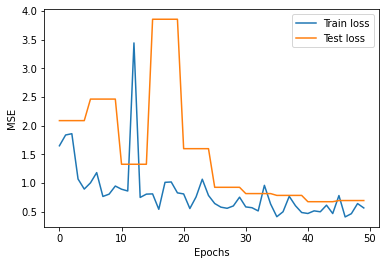

In [10]:
plt.figure()
plt.plot(train_losses, label='Train loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [11]:
ae(X[0].to(device))

(tensor([-0.5766,  0.5739, -0.5321, -0.6015, -0.2893, -0.4144, -0.8106,  0.2558],
        device='cuda:0', grad_fn=<AddBackward0>),
 tensor([ 7.3718e-01,  1.7169e+00,  4.2922e-01,  2.1142e-02, -1.5040e+00,
          8.0608e-01,  8.1190e-01,  7.0453e-01,  9.8067e-01, -7.4372e-01,
         -1.9634e-01, -2.6442e-01,  9.4542e-02,  6.2948e-01, -1.8849e-01,
         -3.6619e-01, -4.5435e-01, -2.2493e-01, -1.0783e+00,  2.1233e-01,
          4.6076e-01,  1.8188e+00,  1.2425e+00,  1.5300e+00,  1.2389e+00,
         -1.0729e+00, -7.8639e-01, -5.4849e-01, -8.5472e-01,  8.0168e-01,
          9.5701e-02,  9.0621e-02, -3.1246e-01, -1.5910e-03,  4.2720e-02],
        device='cuda:0', grad_fn=<AddBackward0>))

In [12]:
X[0]

tensor([ 0.8041,  1.7383,  0.5720, -0.6595, -1.1435,  0.6417,  0.7323,  0.5448,
         2.1698, -1.0089, -0.2682, -0.2943, -0.5681,  0.7509, -0.3924, -0.6105,
         0.0353, -0.2054, -0.4417, -0.6329,  0.0869,  0.3024,  2.5347,  1.1934,
         2.1206, -1.0306, -0.6693, -0.8850, -1.1103,  0.3762,  0.2004,  0.2720,
        -0.9211, -0.3053, -0.3985])